# CSCE 421 :: Machine Learning :: Texas A&M University :: Spring 2023

# Homework 6 (HW-6)
**Name: Arya Rahmanian**  
**UIN: 628003027**  

# Convolutional Neural Networks

In this assignment, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**. 
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary. 
- Once you've filled out your solutions, submit the notebook on Canvas.
- Do **NOT** forget to type in your name and UIN at the beginning of the notebook.

## Data Preparation

#### Install the libraries you need based on your environment

In [1]:
# !pip install ...

In [2]:
# Importing the libraries
import os
import torch
import torchvision
from torchvision.utils import make_grid

import numpy as np

In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [3]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize

In [4]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(),
    Normalize((0.5,), (0.5,))
    ])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

## Data Exploration

Let's take a look at the classes in our dataset.

In [5]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [6]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: {} ({})'.format(dataset.classes[label], label))
    plt.imshow(img.squeeze(), cmap='Greys_r')
    plt.axis(False)

Label: Dress (3)


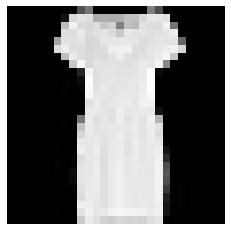

In [7]:
show_example(*dataset[20])

Label: Sneaker (7)


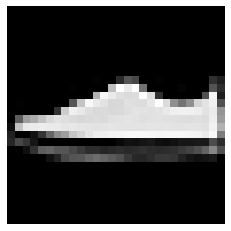

In [8]:
show_example(*dataset[20000])

## Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.  

**Choose a suitable fraction for your validation set and experiment with the seed. Remember that the better your validation set, the higher the chances that your model would do well on the test set.**

In [9]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [10]:
######################
#   YOUR CODE BELOW  #
######################
val_frac =  .4 ## Set the fraction for the validation set
rand_seed =  99 ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("#samples in training set: {}".format(len(train_indices)))
print("#samples in validation set: {}".format(len(val_indices)))

#samples in training set: 36000
#samples in validation set: 24000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide. 

**Set the `batch_size` depending on the hardware resource (GPU/CPU RAM) you are using for the assignment.**

In [11]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [12]:
######################
#   YOUR CODE BELOW  #
######################
batch_size =  64 ## Set the batch size

In [13]:
# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size=batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size=batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 8).permute(1, 2, 0), cmap='Greys_r')
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


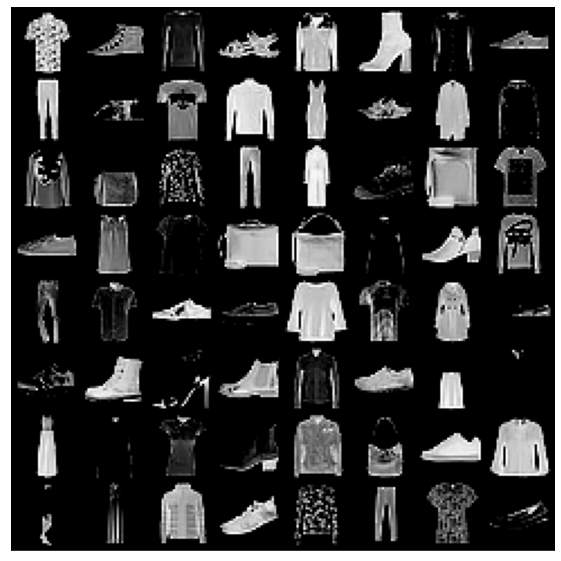

In [15]:
show_batch(train_dl)

## Building the Model

Create your model by defining the network architecture in the `ImageClassifierNet` class.  
**NOTE: The number of parameters in your network must be $\leq$ 100,000.**

In [16]:
# Import the libraries
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [17]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1):
        super(ImageClassifierNet, self).__init__()
        ######################
        #   YOUR CODE HERE   #
        ######################   
           
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=n_channels, out_channels=8, kernel_size=3, padding=1),nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),nn.BatchNorm2d(16),nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fc1 = nn.Linear(in_features=16*6*6, out_features=128)
        self.drop1 = nn.Dropout(p=0.1)
        
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.drop2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, X):
        x = self.layer1(X)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.fc3(x)
        
        return x

In [18]:
model = ImageClassifierNet()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [19]:
summary(model, input_size=(batch_size, 1, 28, 28))

C:\Users\arya_\anaconda3\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
C:\Users\arya_\anaconda3\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [64, 10]                  --
├─Sequential: 1-1                        [64, 8, 14, 14]           --
│    └─Conv2d: 2-1                       [64, 8, 28, 28]           80
│    └─BatchNorm2d: 2-2                  [64, 8, 28, 28]           16
│    └─ReLU: 2-3                         [64, 8, 28, 28]           --
│    └─MaxPool2d: 2-4                    [64, 8, 14, 14]           --
├─Sequential: 1-2                        [64, 16, 6, 6]            --
│    └─Conv2d: 2-5                       [64, 16, 12, 12]          1,168
│    └─BatchNorm2d: 2-6                  [64, 16, 12, 12]          32
│    └─ReLU: 2-7                         [64, 16, 12, 12]          --
│    └─MaxPool2d: 2-8                    [64, 16, 6, 6]            --
├─Linear: 1-3                            [64, 128]                 73,856
├─Dropout: 1-4                           [64, 128]                 --
├─Linear

## Check Model Requirements status

The code block below is to check if your model meets the requirements specefied 

Run the cell to check the status of your model

In [20]:
def check_model(model):
  first_layer = list(model.children())[0]
  last_layer  = list(model.children())[-1]
  num_params = sum(p.numel() for p in model.parameters())
  has_conv1d = False
  has_maxpool2d = False
  first_layer_status= False
  last_layer_status = False

  if isinstance(first_layer, nn.Sequential):
        if isinstance(first_layer[0], nn.Conv2d) and first_layer[0].in_channels == 1:
          first_layer_status= True
  else: 
    if isinstance(first_layer, nn.Conv2d) and first_layer.in_channels == 1:
      first_layer_status= True

  if isinstance(last_layer, nn.Sequential):
    if isinstance(last_layer[-1], nn.Linear) and last_layer[-1].out_features == 10:
      last_layer_status = True
  else:
    print(type(last_layer))
    if isinstance(last_layer, nn.Linear) and last_layer.out_features == 10:
      last_layer_status = True

  for layer in model.modules():
    if isinstance(layer, nn.Conv1d):
        has_conv1d = True
    if isinstance(layer, nn.MaxPool2d):
        has_maxpool2d = True
  flag = False
  if first_layer_status == False:
    print("The very first parameter of the first layer is not 1 nn.Conv2d(1, ....)")
    flag = True
  if last_layer_status == False:
    print("The very last parameter of the last layer is not 10 nn.Linear(..., 10)")
    flag = True
  if has_conv1d == True:
    print("Using nn.Conv1d, which should not happen")
    flag = True
  if has_maxpool2d == False:
    print("No nn.MaxPool2d")
    flag = True
  if num_params > 100000:
    print("Parameters > 100000, please make the network less complex to recieve full grade")
  
  if flag == False:
    print("The Network looks good") 

check_model(model)

<class 'torch.nn.modules.linear.Linear'>
The Network looks good


## Enable training on a GPU

**NOTE:** This section is necessary if you're training your model on a GPU.

In [21]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

to_device(model, device)

ImageClassifierNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (drop2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## Train the model

Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on a validation set.

In [23]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.
    
    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate
    
    Returns:
        The trained model. 
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    loss_list = []
    iteration_list = []
    accuracy_list = []
    
    # Lists for knowing classwise accuracy
    predictions_list = []
    labels_list = []
    count = 0
    # Change learning rate
    for g in opt_fn.param_groups:
        g['lr'] = lr
      
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        train_loss, train_accuracy = 0.0, 0.0  # Track the training loss and accuracy for this epoch
        correct = 0.0 
        total = 0.0
        for inputs, labels in train_dl:
            images, labels = inputs.to(device), labels.to(device) #move to GPU or CPU
            
            outputs = model(images)  # forward pass
            loss = loss_fn(outputs, labels)  #get loss
            opt_fn.zero_grad() 
            loss.backward()  #backward pass
            opt_fn.step()  # update  param
            train_loss += loss.item() * batch_size  #track loss
            _, preds = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            #train_accuracy += torch.sum(preds == labels.data)  # Track the total number of correct predictions

        # compute the average loss and accuracy for this epoch
        train_loss = train_loss
        train_accuracy = 100 * correct / total

        # Set the model to evaluation mode and compute the validation loss and accuracy
        model.eval()
        val_loss, val_accuracy = 0.0, 0.0
        val_total , val_correct = 0.0 , 0.0
        if val_dl:
            with torch.no_grad():
                for inputs, labels in val_dl:
                    images, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item() * batch_size
                    _, preds = torch.max(outputs, 1)

                    val_total += labels.size(0)
                    val_correct += (preds == labels).sum().item()
            val_loss = val_loss
            if val_total != 0:
                val_accuracy = 100 * val_correct / val_total
            else:
                val_accuracy = None
        else:
            val_accuracy = None

        # record the loss and accuracy for this epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print progress
        if val_accuracy is not None:
            print("Epoch {}/{}, train_loss: {:.4f}, val_loss: {:.4f}, train_accuracy: {:.4f}, val_accuracy: {:.4f}"
                  .format(epoch+1, n_epochs, train_loss, val_loss, train_accuracy, val_accuracy))
        else:
            print("Epoch {}/{}, train_loss: {:.4f}, train_accuracy: {:.4f}"
                  .format(epoch+1, n_epochs, train_loss, train_accuracy))
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [24]:
######################
#   YOUR CODE BELOW  #
######################
import torch.optim as optim
from torch.optim import SGD
num_epochs = 10 # Max number of training epochs
loss_fn = nn.CrossEntropyLoss() # Define the loss function
lr = 0.0001 # Set the learning rate
#opt_fn = optim.SGD(model.parameters(), lr=lr)  # Select an optimizer function
opt_fn = torch.optim.Adam(model.parameters(), lr=lr) # Select an optimizer function


In [25]:
history = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)
model, train_losses, val_losses, train_accuracies, val_accuracies = history

Epoch 1/10, train_loss: 30926.7194, val_loss: 12481.6068, train_accuracy: 72.9972, val_accuracy: 81.0167
Epoch 2/10, train_loss: 17382.7508, val_loss: 10437.6591, train_accuracy: 82.7056, val_accuracy: 84.4708
Epoch 3/10, train_loss: 14961.0210, val_loss: 9361.2694, train_accuracy: 85.2306, val_accuracy: 86.1208
Epoch 4/10, train_loss: 13715.2664, val_loss: 8810.9904, train_accuracy: 86.6583, val_accuracy: 86.9417
Epoch 5/10, train_loss: 12864.6839, val_loss: 8529.0573, train_accuracy: 87.3472, val_accuracy: 87.3125
Epoch 6/10, train_loss: 12288.9417, val_loss: 8444.2737, train_accuracy: 88.1389, val_accuracy: 87.5333
Epoch 7/10, train_loss: 11808.3588, val_loss: 8142.9197, train_accuracy: 88.3667, val_accuracy: 87.9750
Epoch 8/10, train_loss: 11470.3335, val_loss: 8126.8042, train_accuracy: 88.8944, val_accuracy: 88.0375
Epoch 9/10, train_loss: 11109.9030, val_loss: 8025.6207, train_accuracy: 89.1833, val_accuracy: 87.9875
Epoch 10/10, train_loss: 10794.1178, val_loss: 7796.1708, trai

## Plot loss and accuracy

Use the code blocks below to check if the model's accuracy increases and the model's loss values decrease throughout the training epochs. If you do not see the expected pattern, you need to go back and make sure the model's training stage is done correctly.

In [ ]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

In [ ]:
plot_accuracy(train_accuracies, val_accuracies)

In [ ]:
def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

In [ ]:
plot_losses(train_losses, val_losses)

## Train a model on the entire dataset

We create a new model with the architecture based on hyperparameter tuning step and train it on the whole training data.

In [30]:
#new_model = ImageClassifierNet()

torch.save(model.state_dict(), 'model.pth')
saved_model = torch.load('model.pth')
print(saved_model.keys())
# Create a new instance of the model
new_model = ImageClassifierNet()

# Update the hyperparameters
new_model.layer1[0].weight.data = saved_model['layer1.0.weight']
new_model.layer1[0].bias.data = saved_model['layer1.0.bias']
new_model.layer1[1].weight.data = saved_model['layer1.1.weight']
new_model.layer1[1].bias.data = saved_model['layer1.1.bias']
new_model.layer1[1].running_mean.data = saved_model['layer1.1.running_mean']
new_model.layer1[1].running_var.data = saved_model['layer1.1.running_var']

new_model.layer2[0].weight.data = saved_model['layer2.0.weight']
new_model.layer2[0].bias.data = saved_model['layer2.0.bias']
new_model.layer2[1].weight.data = saved_model['layer2.1.weight']
new_model.layer2[1].bias.data = saved_model['layer2.1.bias']
new_model.layer2[1].running_mean.data = saved_model['layer2.1.running_mean']
new_model.layer2[1].running_var.data = saved_model['layer2.1.running_var']

new_model.fc1.weight.data = saved_model['fc1.weight']
new_model.fc1.bias.data = saved_model['fc1.bias']
new_model.fc2.weight.data = saved_model['fc2.weight']
new_model.fc2.bias.data = saved_model['fc2.bias']
new_model.fc3.weight.data = saved_model['fc3.weight']
new_model.fc3.bias.data = saved_model['fc3.bias']

odict_keys(['layer1.0.weight', 'layer1.0.bias', 'layer1.1.weight', 'layer1.1.bias', 'layer1.1.running_mean', 'layer1.1.running_var', 'layer1.1.num_batches_tracked', 'layer2.0.weight', 'layer2.0.bias', 'layer2.1.weight', 'layer2.1.bias', 'layer2.1.running_mean', 'layer2.1.running_var', 'layer2.1.num_batches_tracked', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


**NOTE:** The next cell is necessary if you're training your new_model on a GPU.

In [31]:
to_device(new_model, device)

ImageClassifierNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (drop2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [32]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)
dl = DeviceDataLoader(dl, device)

In [33]:
######################
#   YOUR CODE BELOW  #
######################
num_epochs = 20 # Max number of training epochs
lr = 0.0001 # Set the learning rate
history = train_model(num_epochs, new_model, dl, [], loss_fn, opt_fn, lr)
new_model = history[0]

Epoch 1/20, train_loss: 18551.9754, train_accuracy: 89.1117
Epoch 2/20, train_loss: 18563.7283, train_accuracy: 89.0583
Epoch 3/20, train_loss: 18539.2102, train_accuracy: 89.2450
Epoch 4/20, train_loss: 18547.0433, train_accuracy: 89.1117
Epoch 5/20, train_loss: 18597.5750, train_accuracy: 89.1733
Epoch 6/20, train_loss: 18570.5231, train_accuracy: 89.0333
Epoch 7/20, train_loss: 18508.0249, train_accuracy: 89.1883
Epoch 8/20, train_loss: 18588.6492, train_accuracy: 89.1150
Epoch 9/20, train_loss: 18590.7789, train_accuracy: 89.1567
Epoch 10/20, train_loss: 18510.5884, train_accuracy: 89.1233
Epoch 11/20, train_loss: 18547.0466, train_accuracy: 89.2050
Epoch 12/20, train_loss: 18558.4156, train_accuracy: 89.1050
Epoch 13/20, train_loss: 18515.8016, train_accuracy: 89.1667
Epoch 14/20, train_loss: 18540.9467, train_accuracy: 89.1350
Epoch 15/20, train_loss: 18534.6309, train_accuracy: 89.1967
Epoch 16/20, train_loss: 18549.1124, train_accuracy: 89.1617
Epoch 17/20, train_loss: 18569.41

## Check Predictions

In [34]:
def view_prediction(img, label, probs, classes):
    """
    Visualize predictions.
    """
    probs = probs.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(8,15), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze(), cmap='Greys_r')
    ax1.axis('off')
    ax1.set_title('Actual: {}'.format(classes[label]))
    ax2.barh(np.arange(10), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes, size='small');
    ax2.set_title('Predicted: probabilities')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

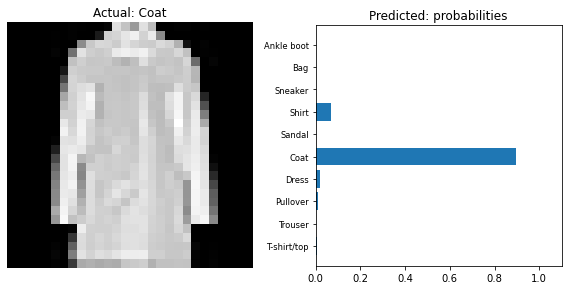

In [51]:
# Calculate the class probabilites (log softmax) for img
images = iter(dl)
for imgs, labels in images:
    with torch.no_grad():
        new_model.eval()
        # Calculate the class probabilites (log softmax) for img
        probs = torch.nn.functional.softmax(new_model(imgs[0].unsqueeze(0)), dim=1)
        # Plot the image and probabilites
        view_prediction(imgs[0], labels[0], probs, dataset.classes)
    break

## Save the model

In [52]:
torch.save(new_model, 'new_model')

## Compute accuracy on the test set

Here we load the test data pickle file provided.

You need to provide the path for the test_data pickle file and run the cells.

In [53]:
import pickle

In [54]:
######################
#  YOUR Answer BELOW #
######################
test_dataset_file_path = "test_data.pickle"

with open(test_dataset_file_path, 'rb') as f:
    test_dataset = pickle.load(f)

In [55]:
test_dl = DataLoader(test_dataset, batch_size)
test_dl = DeviceDataLoader(test_dl, device)

In [56]:
def evaluate(model, test_dl):
    with torch.no_grad():
        model.eval()
        total_test_dl = 0
        preds, labels = [], []
        for xb, yb in test_dl:
            # Model output
            y_pred = model(xb)
            _, y_pred = torch.max(y_pred, dim=1)
            preds.extend(y_pred)
            labels.extend(yb)               
            total_test_dl += len(yb)

    preds, labels = torch.tensor(preds), torch.tensor(labels)
    test_accuracy = torch.sum(preds == labels).item() / len(preds)
    return test_accuracy

In [57]:
print("Test Accuracy = {:.4f}".format(evaluate(new_model, test_dl)))

Test Accuracy = 0.8752
